Dataset shape after processing: (489843, 41)
Optimal number of clusters found: 20


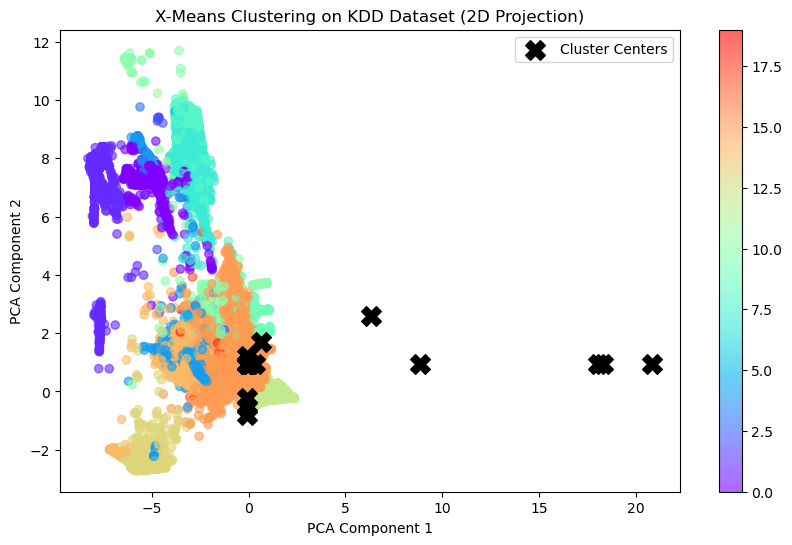

cluster
12.0    281022
13.0     86525
15.0     85320
0.0      21154
4.0       4809
7.0       4007
14.0      2224
1.0       1625
8.0       1180
9.0       1088
10.0       405
17.0       225
18.0       201
16.0        24
6.0         13
2.0         11
11.0         4
3.0          4
19.0         1
5.0          1
Name: count, dtype: int64
Detected Anomalous Clusters: [12.0, 13.0, 15.0, 0.0]


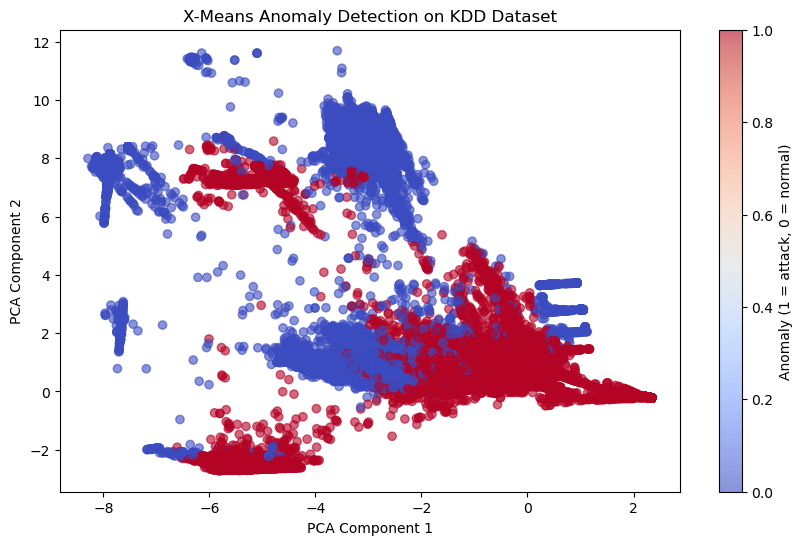

Accuracy: 0.9176
F1 Score: 0.8881
                  precision    recall  f1-score   support

        apache2.       0.00      0.00      0.00        84
           back.       0.00      0.00      0.00       108
buffer_overflow.       0.00      0.00      0.00         1
   guess_passwd.       1.00      0.16      0.28       425
     httptunnel.       0.00      0.00      0.00         7
        ipsweep.       0.90      0.90      0.90        29
           land.       1.00      1.00      1.00         1
       mailbomb.       0.00      0.00      0.00       508
          mscan.       1.00      0.21      0.35       109
       multihop.       0.00      0.00      0.00         3
          named.       0.00      0.00      0.00         4
        neptune.       0.98      1.00      0.99      5825
           nmap.       0.00      0.00      0.00        13
         normal.       0.74      0.98      0.84      6228
            pod.       0.00      0.00      0.00         6
      portsweep.       0.00      0.00

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from scipy.stats import zscore
import warnings

np.warnings = warnings

# Identify categorical features.
categorical_cols = ['protocol_type', 'service', 'flag']

# Load data into a DataFrame
df = pd.read_csv("kddcup.data.gz", compression='gzip', header=None)
test_df = pd.read_csv("corrected.gz", compression='gzip', header=None)

df = df.sample(frac=0.1, replace=False)
test_df = test_df.sample(frac=0.1, replace=False)

all_features = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_count',
    'dst_host_diff_srv_count', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'target'
]

df.columns = all_features
test_df.columns = all_features

df = df.drop(columns=['target'])  # Adjust 'label' to the correct target column

# Drop any rows with missing values (if applicable)
df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Encode categorical variables
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])
    test_df[col] = encoder.fit_transform(test_df[col])

# Normalize features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
test_df_scaled = scaler.transform(test_df.drop(columns=['target']))  # Transform the test set

print(f"Dataset shape after processing: {df_scaled.shape}")

# Initialize centers
initial_centers = kmeans_plusplus_initializer(df_scaled, 2).initialize()

# Run X-Means Clustering
xmeans_instance = xmeans(df_scaled, initial_centers)
xmeans_instance.process()

# Get cluster results
clusters = xmeans_instance.get_clusters()
final_centers = xmeans_instance.get_centers()

print("Optimal number of clusters found:", len(clusters))

# Create an array to store cluster labels for each data point
cluster_labels = np.zeros(len(df_scaled))  

# Assign each point to its corresponding cluster
for cluster_idx, cluster_points in enumerate(clusters):
    for point_idx in cluster_points:
        cluster_labels[point_idx] = cluster_idx

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Plot Clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='rainbow', alpha=0.6)
plt.scatter(np.array(final_centers)[:, 0], np.array(final_centers)[:, 1], c='black', marker='X', s=200, label='Cluster Centers')

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Clustering on KDD Dataset (2D Projection)")
plt.legend()
plt.colorbar(scatter)
plt.show()

# Add clusters to original data frame.
df['cluster'] = cluster_labels

# Show distribution of points in each cluster
print(df['cluster'].value_counts())

# Find cluster sizes
cluster_sizes = df['cluster'].value_counts()
Q1 = cluster_sizes.quantile(0.25)
Q3 = cluster_sizes.quantile(0.75)
IQR = Q3 - Q1

# Try reducing the multiplier from 1.5 to 1.0 or 0.75
lower_bound = Q1 - 1.0 * IQR  # Stricter detection
upper_bound = Q3 + 1.0 * IQR  # Can also check large clusters

anomalous_clusters = cluster_sizes[(cluster_sizes < lower_bound) | (cluster_sizes > upper_bound)].index.tolist()

print("Detected Anomalous Clusters:", anomalous_clusters)

# Add anomaly column (1 if in an anomalous cluster, else 0)
df['anomaly'] = df['cluster'].apply(lambda x: 1 if x in anomalous_clusters else 0)

# Visualize Anomalies in 2D
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("X-Means Anomaly Detection on KDD Dataset")
plt.colorbar(label="Anomaly (1 = attack, 0 = normal)")
plt.show()

# Predict clusters for the test data
test_clusters = xmeans_instance.predict(test_df_scaled)

# Assign the cluster labels to the test set
test_df['cluster'] = test_clusters

# Map each cluster to the most common attack/normal label in the test set
cluster_mapping = test_df.groupby('cluster')['target'].agg(lambda x: x.value_counts().idxmax())

# Assign predicted labels
test_df['predicted_label'] = test_df['cluster'].map(cluster_mapping).fillna('unknown')

# Drop NaN values if any clusters were not mapped
test_df = test_df.dropna(subset=['predicted_label'])

# Compute evaluation metrics
accuracy = accuracy_score(test_df['target'], test_df['predicted_label'])
f1 = f1_score(test_df['target'], test_df['predicted_label'], average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report with zero_division
print(classification_report(test_df['target'], test_df['predicted_label'], zero_division=0))